# Bridge crossing example

In this notebook we implement several algorithms of ["Reinforcement learning - An introduction" book](https://webdocs.cs.ualberta.ca/~sutton/book/the-book-2nd.html) for the basic example of 'Bridge crossing' problem. Below one can find the following algorithms applied to the example:

**A) Modeled environment, Dynamic Programming**

- Iterative solution of Bellman equation for *value function*
- Greedy policy improvement
- Policy iteration algorithm
- Value iteration algorithm

**B) Monte Carlo methods**

- First-visit policy evaluation
- Exploring Starts
- On-policy first-visit

**C) Temporal Difference methods**

- SARSA
- Q-learning 


## Example description

We have a 2D grid of size `6x3` with a bridge over the pit. 

``` 
 _ _ _ _ _ _
|_|X|X|X|X|_|
|S|_|_|_|_|E|
|_|X|X|X|X|_|
```
where `S` denotes the staring position, `E` - end position and `X` corresponds to the pit.

Model is defined as following :
- States : $(x, y)$ positions on the grid
- Actions : `[North, South, West, East]` moves
- Rewards : `[Fail, Success, Step]` reward values

We assume the environment to be deterministic by the probability $p(s',r \mid s,a)$. For example

$$
p(S+(1,0),r \mid s=S,a=\text{West}) = 1.0 \, \text{for only}\, r=\text{Step}, \\
p(S+(0,1),r \mid s=S,a=\text{North}) = 1.0 \, \text{for only}\, r=\text{Step}, \\
p(S+(0,-1),r \mid s=S,a=\text{South}) = 1.0 \, \text{for only}\, r=\text{Step}
$$


In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
ACTIONS = ['W', 'N', 'E', 'S']
REWARDS = [-10, 10, 0]  # Fail, Success, Step

GRID_WIDTH = 6
GRID_HEIGHT = 3
GRID = np.zeros((GRID_HEIGHT, GRID_WIDTH))
GRID[0, 1:GRID_WIDTH-1] = GRID[2, 1:GRID_WIDTH-1] = -1.0

START_POS = (0, 1)
END_POS = (GRID_WIDTH - 1, 1)

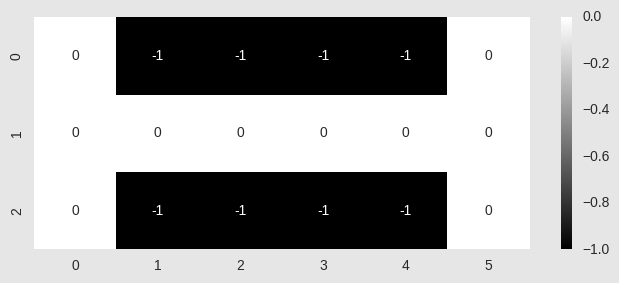

In [3]:
with sns.axes_style('dark', {'figure.facecolor': '0.90'}):
    plt.figure(figsize=(8,3))
    sns.heatmap(GRID, cmap='gray', annot=True, fmt="0.0f")

In [4]:
def on_grid(x, y):
    return 0 <= x < GRID_WIDTH and 0 <= y < GRID_HEIGHT 

def in_pit(x, y):
    return GRID[GRID_HEIGHT - 1 - y, x] < 0.0

def on_bridge(x, y):
    return not in_pit(x, y)

def at_end_position(x, y):
    return x == END_POS[0] and y == END_POS[1]

def take_action(state, action):
    x, y = state
    if action == 'N':
        return (x, y+1)
    elif action == 'W':
        return (x-1, y)
    elif action == 'E':
        return (x+1, y)
    elif action == 'S':
        return (x, y-1)
    else:
        raise Exception("Unknown action : {}".format(action))
    

def bridge_proba(new_state, reward, state, action):
    x, y = state
    nx, ny = new_state
    if not on_grid(x, y) or not on_grid(nx, ny):
        return 0.0
    
    if action == 'N':
        if ny != y + 1 or nx != x or in_pit(x, y):
            return 0.0
        elif in_pit(nx, ny) and reward == REWARDS[0]:
            return 1.0
        elif at_end_position(nx, ny) and reward == REWARDS[1]:
            return 1.0
        elif on_bridge(nx, ny) and not at_end_position(nx, ny) and reward == REWARDS[2]:
            return 1.0
        else:
            return 0.0
    elif action == 'S':
        if ny != y - 1 or nx != x or in_pit(x, y):
            return 0.0
        elif in_pit(nx, ny) and reward == REWARDS[0]:
            return 1.0
        elif at_end_position(nx, ny) and reward == REWARDS[1]:
            return 1.0
        elif on_bridge(nx, ny) and not at_end_position(nx, ny) and reward == REWARDS[2]:
            return 1.0
        else:
            return 0.0
    elif action == 'W':
        if ny != y or nx != x - 1 or in_pit(x, y):
            return 0.0
        elif in_pit(nx, ny) and reward == REWARDS[0]:
            return 1.0
        elif at_end_position(nx, ny) and reward == REWARDS[1]:
            return 1.0
        elif on_bridge(nx, ny) and not at_end_position(nx, ny) and reward == REWARDS[2]:
            return 1.0
        else:
            return 0.0
    elif action == 'E':
        if ny != y or nx != x + 1 or in_pit(x, y):
            return 0.0
        elif in_pit(nx, ny) and reward == REWARDS[0]:
            return 1.0
        elif at_end_position(nx, ny) and reward == REWARDS[1]:
            return 1.0
        elif on_bridge(nx, ny) and not at_end_position(nx, ny) and reward == REWARDS[2]:
            return 1.0
        else:
            return 0.0

Check the probability normalization:

In [5]:
for x in range(GRID_WIDTH):
    for y in range(GRID_HEIGHT):
        for action in ACTIONS:
            if in_pit(x, y):
                continue
            nx, ny = take_action((x, y), action)
            if not on_grid(nx, ny):
                continue
            p = 0
            for nx in range(GRID_WIDTH):
                for ny in range(GRID_HEIGHT):
                    for r in REWARDS:
                        p += bridge_proba((nx, ny), r, (x, y), action)
            assert p == 1, "Total probability is not 1, p={} for state=({}, {}) and action={}".format(p, x, y, action)

Using environment model one can compute anything else one might want to know about the environment
- expected rewards for state–action pairs : $r(s,a) = \mathbb{E}[R_{t+1} | S_t = s, A_t = a ] = \sum_{r \in \cal{R}} r \sum_{s' \in \cal{S}} p(s',r \mid s,a)$
- state-transition probabilities : $p(s' \, | \, s, a) = \sum_{r \in \cal{R}} p(s',r \mid s,a)$

In [6]:
def reward(state, action):
    reward = 0
    for r in REWARDS:
        p = 0
        for x in range(GRID_WIDTH):
            for y in range(GRID_HEIGHT):
                p += bridge_proba((x, y), r, state, action)
        reward += r * p    
    return reward

def state_transition_proba(new_state, state, action):
    p = 0
    for r in REWARDS:
        p += bridge_proba(new_state, r, state, action)
    return p
    

reward((0, 1), 'E'), reward((1, 1), 'S'), state_transition_proba((0, 1), (0, 0), 'N'), state_transition_proba((1, 0), (0, 0), 'W')

(0.0, -10.0, 1.0, 0.0)

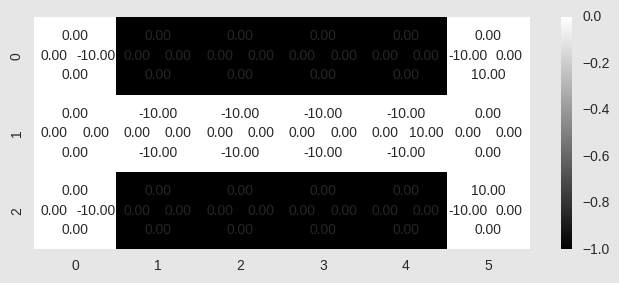

In [7]:
def display_state_action_func(state_action_func):
    positions = {'N': [0.0, 0.25], 'S': [0.0, -0.25], 'W': [-0.25, 0.0], 'E': [0.25, 0.0]}
    with sns.axes_style('dark', {'figure.facecolor': '0.90'}):
        plt.figure(figsize=(8,3))
        sns.heatmap(GRID, cmap='gray')
        for y in range(GRID_HEIGHT):
            for x in range(GRID_WIDTH):
                for i, a in enumerate(ACTIONS):
                    pr = state_action_func((x, y), a)
                    plt.text(x + 0.5 + positions[a][0], y + 0.5 + positions[a][1], "%0.2f" % pr, va='center', ha='center')

display_state_action_func(reward) 

## Value function and policy evaluation

### Bellman equation

Next we introduce *Bellman equation* for the *value function* :
$$
v_{\pi}(s) = \mathbb{E}_{\pi}[G_t \mid S_t=s] = \sum_{a} \pi(a \mid s) \sum_{s', r} p(s',r \mid s, a) \left[ r + \gamma v_{\pi}(s')\right],
$$
where $\mathbb{E}_{\pi}[.]$ denotes an expected value of a random variable given that the agent follows the policy $\pi$, $G_t$ is a discounted return defined as 
$$
G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$
Here $R_{t+k}$ defines a reward random variable at step $t+k$.

We want to estimate *value functions* using the above equation. Let us define several policy functions $\pi_i(a \mid s)$. Policy function is a mapping from each state $s \in \cal{S}$ and action $a \in \cal{A}$ to probability of taking action $a$ when in state $s$

In [8]:
def get_cross_bridge_actions(state, new_state_cond):
    x, y = state
    if in_pit(x, y):
        return []    
    actions = []
    for a in ACTIONS:
        nx, ny = take_action(state, a)
        if new_state_cond(nx, ny):
            actions.append(a)
    return actions

def default_policy(state, action):
    if at_end_position(state[0], state[1]):
        return 0.0
    
    actions = get_cross_bridge_actions(state, lambda nx, ny: on_grid(nx, ny) and on_bridge(nx, ny))
    if action not in actions:
        return 0.0 
    else:
        if action == 'E':
            return 0.75
        else:
            return 0.25 / (len(actions) - 1) if len(actions) > 1 else 1.0

def another_policy(state, action):
    if at_end_position(state[0], state[1]):
        return 0.0
    actions = get_cross_bridge_actions(state, lambda nx, ny: on_grid(nx, ny))
    if action not in actions:
        return 0.0 
    else:
        if action == 'E':
            return 0.75
        else:
            return 0.25 / (len(actions) - 1) if len(actions) > 1 else 1.0

def some_other_policy(state, action):
    if at_end_position(state[0], state[1]):
        return 0.0
    actions = get_cross_bridge_actions(state, lambda nx, ny: on_grid(nx, ny))
    if action not in actions:
        return 0.0 
    if len(actions) > 0:
        return 1.0 / len(actions)
    else:
        return 0.0

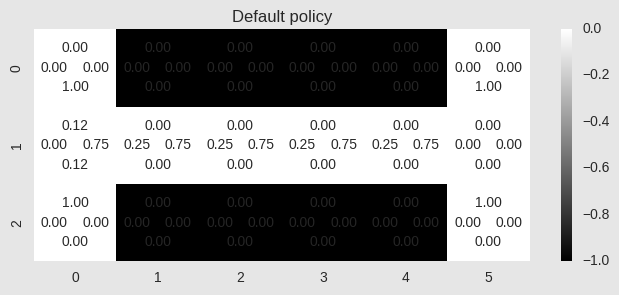

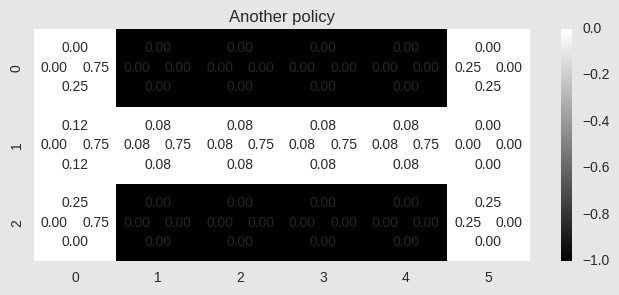

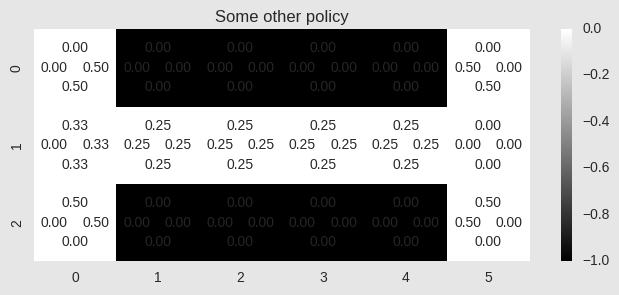

In [9]:
display_state_action_func(default_policy)
plt.title("Default policy")
display_state_action_func(another_policy)
plt.title("Another policy")
display_state_action_func(some_other_policy)
plt.title("Some other policy")

First policy function `default_policy` suggests to move to the right and avoid to fall in the pit. We will see later that this policy provides the *optimal value function*. Second policy function `another_policy` also suggests to move to the right and has non-zero probabilities to fall in the pit. The third policy, as it is shown on the plot, has equal probabilities to move anywhere: cross the bridge and fall to the pit.

### Policy evaluation
In the following snippet we implement methods to compute right-hand side of Bellman equation and the error between left-hand side and right-hand side computed over all state for a given value function. 

In [10]:
def Bellman_equation_RHS(state, value_function, policy, model_proba, gamma):
    x, y = state
    res = 0
    for a in ACTIONS:
        p = 0
        for xp in range(GRID_WIDTH):
            for yp in range(GRID_HEIGHT):
                for r in REWARDS:
                    t = (r + gamma * value_function[GRID_HEIGHT - 1 - yp, xp])
                    t *= model_proba((xp, yp), r, state, a)
                    p += t
        res += p * policy(state, a)
    return res

def Bellman_equation(value_function, policy, model_proba, gamma):
    """
    Method to compute difference between left and right hand sides of Bellman equation for all states
    :return: sum(abs(LHS - RHS)) for all states
    """
    err = 0
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT): 
            lhs = value_function[GRID_HEIGHT - 1 - y, x]
            rhs = Bellman_equation_RHS((x, y), value_function, policy, model_proba, gamma)
            err += np.abs(lhs - rhs)
    return err

In [11]:
value_function = np.zeros((GRID_HEIGHT, GRID_WIDTH))

Bellman_equation_RHS((0, 0), value_function, default_policy, bridge_proba, 0.8), \
    Bellman_equation_RHS((GRID_WIDTH-1, 1), value_function, default_policy, bridge_proba, 0.8), \
    Bellman_equation_RHS((0, 1), value_function, default_policy, bridge_proba, 0.8), \
    Bellman_equation(value_function, default_policy, bridge_proba, 0.8)

(0.0, 0.0, 0.0, 27.5)

Initialize value function by some random values and solve Bellman equation iteratively (*iterative policy evaluation*). In terminal states, value function $v_{\pi}(\cal{S}^{+})$ is zero.

In [12]:
def init_value_function():
    value_function = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT): 
            if on_bridge(x, y):
                if at_end_position(x, y):
                    value_function[y, x] = 0.0
                else:
                    value_function[y, x] = np.random.rand()
    return value_function

def compute_value_function(policy, gamma):
    value_function = init_value_function()
        
    min_err = 1e-7
    err = Bellman_equation(value_function, policy, bridge_proba, gamma)
    count = 0
    while min_err < err:
        if count % 10 == 0:
            print("Iteration : %i, err: %f" % (count, err))
        count += 1
        for x in range(GRID_WIDTH):
            for y in range(GRID_HEIGHT):
                rhs = Bellman_equation_RHS((x, y), value_function, policy, bridge_proba, gamma)
                value_function[GRID_HEIGHT - 1 - y, x] = rhs
                
        err = Bellman_equation(value_function, policy, bridge_proba, gamma)
        
    return value_function


gamma = 0.7

value_function_1 = compute_value_function(default_policy, gamma)
value_function_2 = compute_value_function(another_policy, gamma)
value_function_3 = compute_value_function(some_other_policy, gamma)
    
Bellman_equation(value_function_1, default_policy, bridge_proba, gamma), \
Bellman_equation(value_function_2, another_policy, bridge_proba, gamma), \
Bellman_equation(value_function_3, some_other_policy, bridge_proba, gamma)

Iteration : 0, err: 26.906177
Iteration : 10, err: 0.003479
Iteration : 0, err: 29.842884
Iteration : 10, err: 0.000002
Iteration : 0, err: 30.748563
Iteration : 10, err: 0.000013


(9.4261017657970569e-08, 1.9978682708199358e-08, 2.6288494048287703e-08)

Next we can plot value functions for three policies:

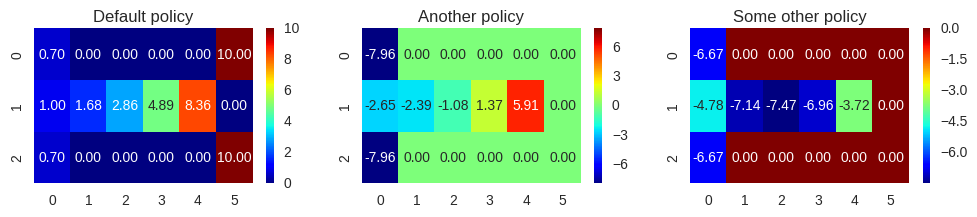

In [13]:
plt.figure(figsize=(12, 2))
plt.subplot(131)
sns.heatmap(value_function_1, annot=True, fmt="0.2f", cmap='jet')
plt.title("Default policy")

plt.subplot(132)
sns.heatmap(value_function_2, annot=True, fmt="0.2f", cmap='jet')
plt.title("Another policy")

plt.subplot(133)
sns.heatmap(value_function_3, annot=True, fmt="0.2f", cmap='jet')
plt.title("Some other policy")

### Action value function

We can also compute a function that gives a value of taking action $a$ in state $s$ under policy $\pi$, *action value function*.

It is defined similarly to value function as 
$$
q_{\pi}(a, s) = \mathbb{E}_{\pi}[G_t \mid S_t=s, A_t=a]
$$

We can compute it using the following formula :
$$
q_{\pi}(a, s) = \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma v_{\pi}(s') \right]
$$


In [14]:
def action_value_function(state, action, value_function, model_proba, gamma):
    res = 0
    for xp in range(GRID_WIDTH):
        for yp in range(GRID_HEIGHT):
            v = value_function[GRID_HEIGHT - 1 -yp, xp]
            for r in REWARDS:
                t = r + gamma * v
                t *= model_proba((xp, yp), r, state, action)
                res += t
    return res

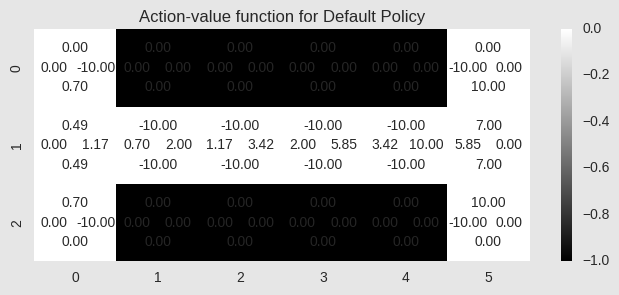

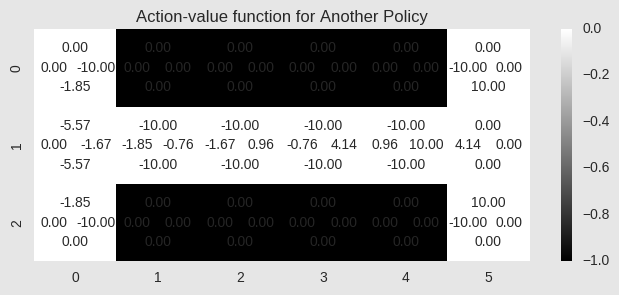

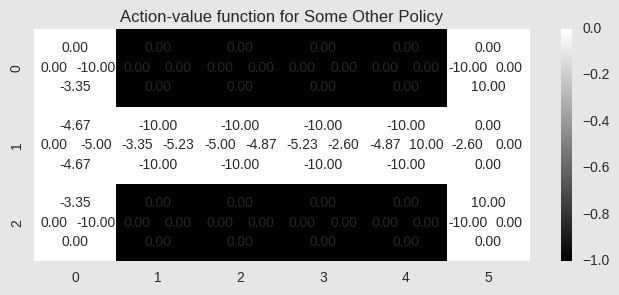

In [15]:
action_value_function_1 = lambda state, action: action_value_function(state, action, value_function_1, bridge_proba, gamma)
display_state_action_func(action_value_function_1)
plt.title("Action-value function for Default Policy")

action_value_function_2 = lambda state, action: action_value_function(state, action, value_function_2, bridge_proba, gamma)
display_state_action_func(action_value_function_2)
plt.title("Action-value function for Another Policy")

action_value_function_3 = lambda state, action: action_value_function(state, action, value_function_3, bridge_proba, gamma)
display_state_action_func(action_value_function_3)
plt.title("Action-value function for Some Other Policy")

*Optimal value function* is defined as $v_*(s) = \max_{\pi} v_{\pi}(s)$ for all $s \in \cal{S}$

In [16]:
vfs = [value_function_2, value_function_3, value_function_1]

optimal = np.argmax([f[GRID_HEIGHT-1,0] for f in vfs])

for x in range(GRID_WIDTH):
    for y in range(GRID_HEIGHT):
        vals = [f[y,x] for f in vfs]
        new_optimal = np.argmax(vals)
        if optimal != new_optimal and vals[new_optimal] != vals[optimal] :
            print("No optimal value function")
            break
    if optimal != new_optimal:
        break
        
(vfs[optimal] == value_function_1).all()

True

## Policy iteration

### Greedy policy improvement

We can improve the policy with a value function in *greedy* manner : $\pi'(s) = \text{argmax}_{a} q_{\pi}(s, a)$. The greedy policy takes the action that looks best in the short term. We remark that the *greedy* policy becomes deterministic, it return one action for a given state.

In [17]:
def greedy_policy(state, action_value_func):
    q_vals = [action_value_func(state, a) for a in ACTIONS]
    max_index = np.argmax(q_vals)
    return ACTIONS[max_index]

In [18]:
def display_policy_arr(policy_arr):
    sns.heatmap(GRID, cmap='gray')
    for y in range(GRID_HEIGHT):
        for x in range(GRID_WIDTH):
            a = policy_arr[y, x]
            plt.text(x + 0.5, y + 0.5, "%s" % a, va='center', ha='center')                    

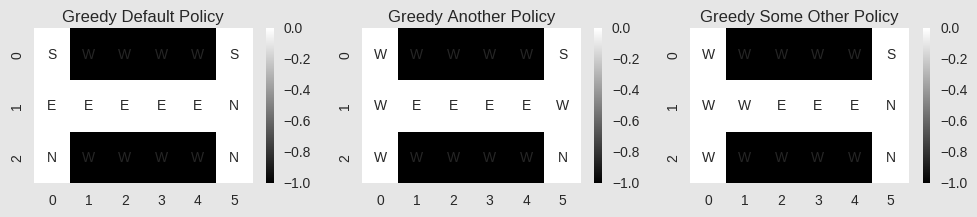

In [19]:
def compute_greedy_policy(action_value_func):
    greedy_policy_arr = np.empty((GRID_HEIGHT, GRID_WIDTH), dtype=np.object)
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT):
            greedy_policy_arr[y, x] = greedy_policy((x, y), action_value_func)
    return greedy_policy_arr

greedy_default_policy_arr = compute_greedy_policy(action_value_function_1)
greedy_another_policy_arr = compute_greedy_policy(action_value_function_2)
greedy_some_other_policy_arr = compute_greedy_policy(action_value_function_3)

with sns.axes_style('dark', {'figure.facecolor': '0.90'}):
    fig = plt.figure(figsize=(12,2))
    plt.subplot(131)
    plt.title("Greedy Default Policy")
    display_policy_arr(greedy_default_policy_arr)
    plt.subplot(132)
    plt.title("Greedy Another Policy")
    display_policy_arr(greedy_another_policy_arr)
    plt.subplot(133)
    plt.title("Greedy Some Other Policy")
    display_policy_arr(greedy_some_other_policy_arr)

Next we can perform policy iteration procedure starting from, for example, `another_policy`

In [20]:
# Method similar to compute_value_function
def policy_evaluation(policy_arr, value_function, gamma):
    min_err = 1e-7
    err = 1e10
    count = 0
    while min_err < err and count < 1000:
        count += 1
        err = 0.0
        for x in range(GRID_WIDTH):
            for y in range(GRID_HEIGHT):
                # Force value function to be zero at the terminal state
                if at_end_position(x, y):
                    value_function[GRID_HEIGHT - 1 - y, x] = 0.0
                else:
                    action = policy_arr[y, x]
                    v = value_function[GRID_HEIGHT - 1 - y, x]
                    value_function[GRID_HEIGHT - 1 - y, x] = action_value_function((x, y), action, value_function, bridge_proba, gamma)
                    err = max(err, np.abs(v - value_function[GRID_HEIGHT - 1 - y, x]))
    return value_function


def policy_iteration(init_policy_arr, gamma):
    is_policy_stable = False
    # Initialization:
    greedy_policy_arr = init_policy_arr.copy()    
    value_function = init_value_function()
    
    count = 0
    while not is_policy_stable and count < 100:
        
        # Policy evaluation
        value_function = policy_evaluation(greedy_policy_arr, value_function, gamma)
    
        # Policy improvement
        is_policy_stable = True
        avf = lambda state, action: action_value_function(state, action, value_function, bridge_proba, gamma)
        for x in range(GRID_WIDTH):
            for y in range(GRID_HEIGHT):
                old_action = greedy_policy_arr[y, x]
                greedy_policy_arr[y, x] = greedy_policy((x, y), avf)
                if old_action != greedy_policy_arr[y, x]:
                    is_policy_stable = False

        count += 1
    return greedy_policy_arr, value_function
    

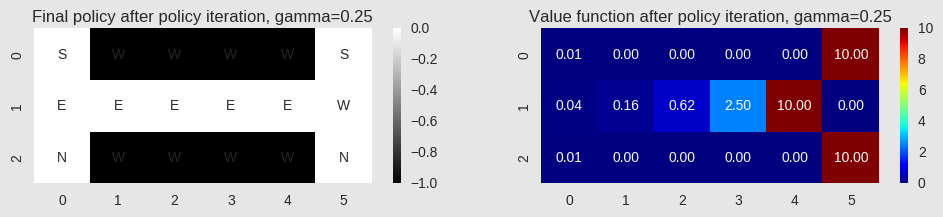

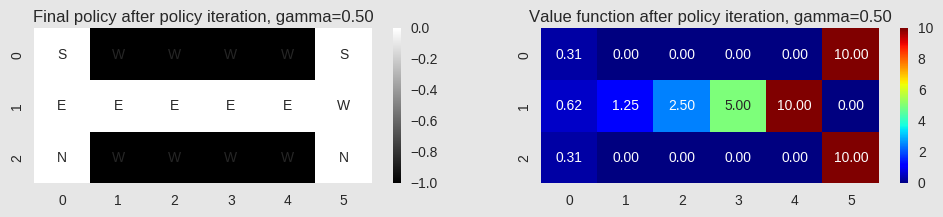

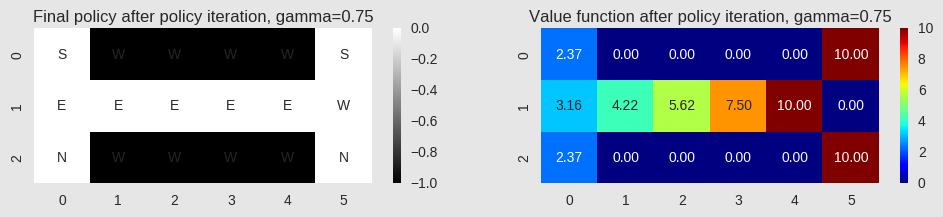

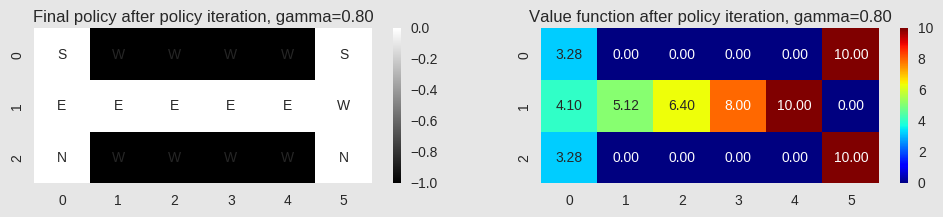

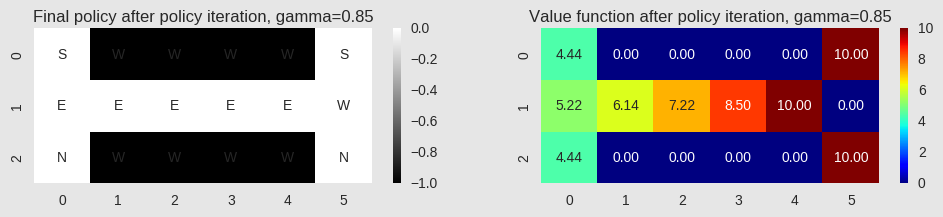

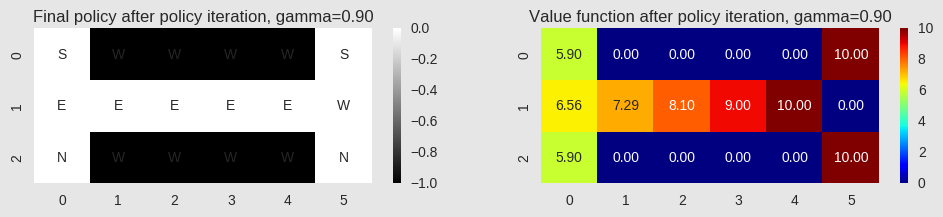

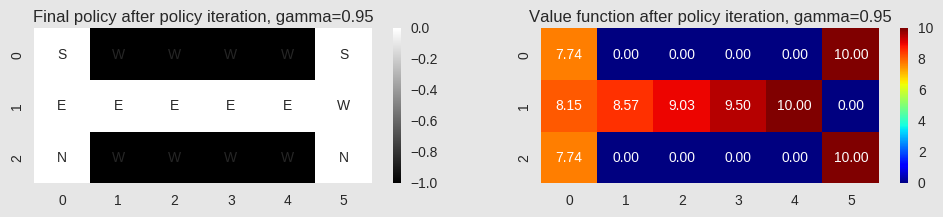

In [21]:
with sns.axes_style('dark', {'figure.facecolor': '0.90'}):
    for i, gamma in enumerate([0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95]):
        fig = plt.figure(figsize=(12, 2))
        final_policy_arr, final_value_function = policy_iteration(greedy_some_other_policy_arr, gamma)
        plt.subplot(121)    
        plt.title("Final policy after policy iteration, gamma=%0.2f" % gamma)
        display_policy_arr(final_policy_arr)
        plt.subplot(122)    
        plt.title("Value function after policy iteration, gamma=%0.2f" % gamma)
        sns.heatmap(final_value_function, annot=True, fmt="0.2f", cmap='jet')
        

## Value iteration

One drawback to policy iteration is that each of its iterations involves policy evaluation, which may itself be a protracted iterative computation requiring multiple sweeps through the state set. If policy evaluation is done iteratively, then convergence exactly to $v_{\pi}$ occurs only in the limit.

In [22]:
def value_iteration(gamma):
    value_function = init_value_function()
    
    min_err = 1e-7
    err = 1e10
    count = 0
    while min_err < err and count < 1000:
        count += 1
        err = 0.0
        for x in range(GRID_WIDTH):
            for y in range(GRID_HEIGHT):
                # Force value function to be zero at the terminal state
                if at_end_position(x, y):
                    value_function[GRID_HEIGHT - 1 - y, x] = 0.0
                else:
                    v = value_function[GRID_HEIGHT - 1 - y, x]
                    vals = [action_value_function((x, y), action, value_function, bridge_proba, gamma) for action in ACTIONS]                    
                    value_function[GRID_HEIGHT - 1 - y, x] = np.max(vals)
                    err = max(err, np.abs(v - value_function[GRID_HEIGHT - 1 - y, x]))
    

    avf = lambda state, action: action_value_function(state, action, value_function, bridge_proba, gamma)
    greedy_policy_arr = compute_greedy_policy(avf)
    return greedy_policy_arr, value_function

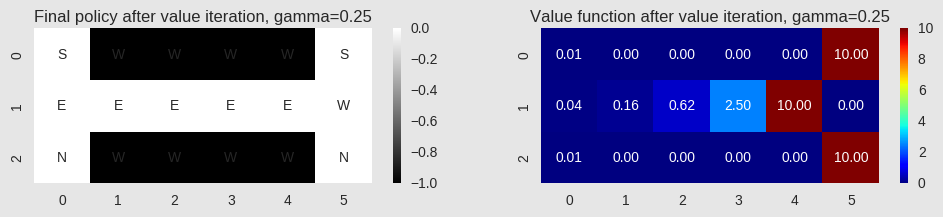

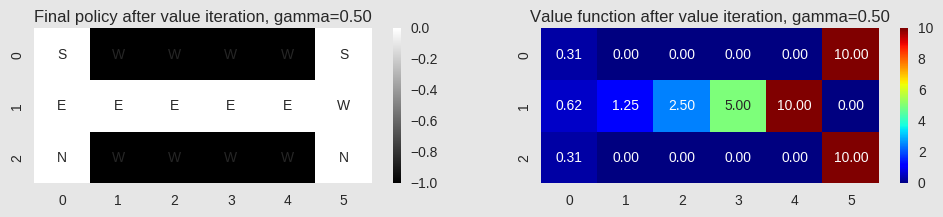

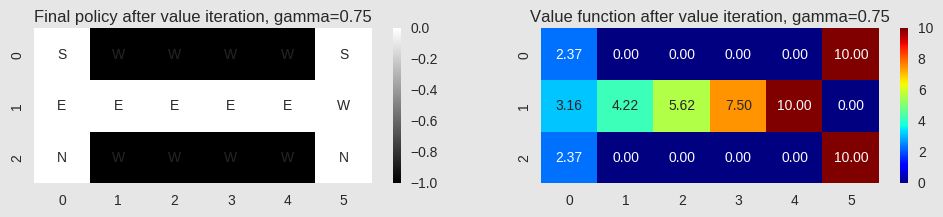

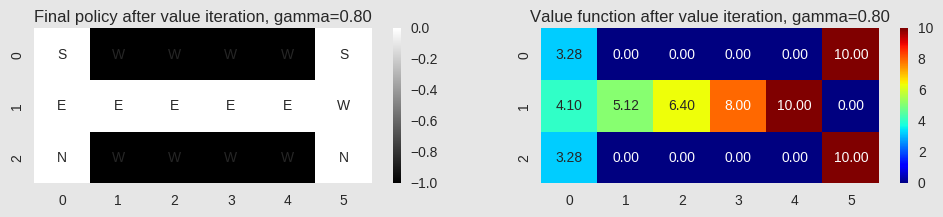

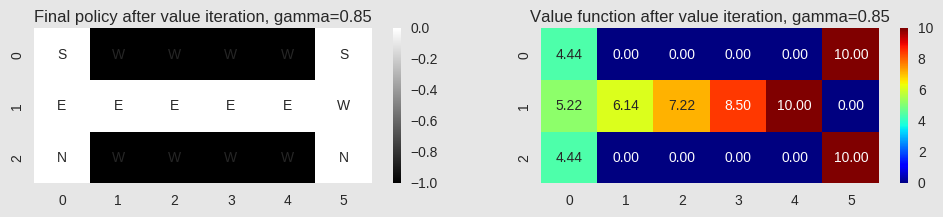

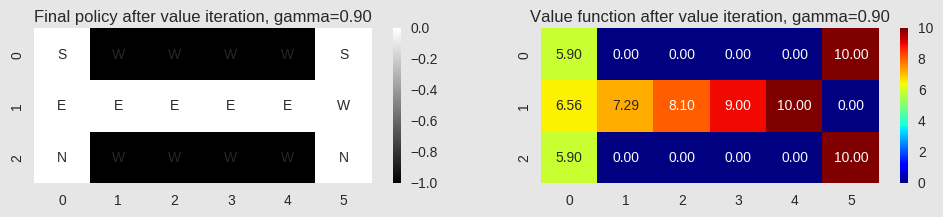

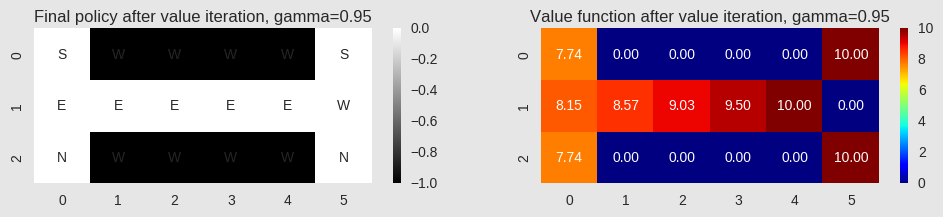

In [23]:
with sns.axes_style('dark', {'figure.facecolor': '0.90'}):
    for i, gamma in enumerate([0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95]):
        fig = plt.figure(figsize=(12, 2))
        final_policy_arr, final_value_function = value_iteration(gamma)
        plt.subplot(121)    
        plt.title("Final policy after value iteration, gamma=%0.2f" % gamma)
        display_policy_arr(final_policy_arr)
        plt.subplot(122)    
        plt.title("Value function after value iteration, gamma=%0.2f" % gamma)
        sns.heatmap(final_value_function, annot=True, fmt="0.2f", cmap='jet')
        

## Monte Carlo methods

In contrast to the previous methods, we do not assume complete knowledge of the environment. Monte Carlo methods require only experience—sample sequences of states, actions, and rewards from actual or simulated interaction with an environment. Learning from actual experience is striking because it requires no prior knowledge of the environment's dynamics, yet can still attain optimal behavior. 

### First-visit MC policy evaluation

Method estimates $v_{\pi}(s)$ as the average of the returns following the first visits to the state $s$.



In [24]:
def generate_episode(policy_arr, initial_state=None, initial_action=None):
    reward = 0    
    episode = [[START_POS, initial_action]] if initial_state is None else [[initial_state, initial_action]]
    state, action = episode[-1]
    episode_length = GRID_HEIGHT + GRID_WIDTH
    while episode_length > 0:
        episode_length -= 1        
        x, y = state
        if action is None:
            action = policy_arr[y, x] 
            episode[-1][1] = action
            
        nx, ny = take_action(state, action)
        if not on_grid(nx, ny):
            reward += REWARDS[2]
            continue
        elif on_bridge(nx, ny) and not at_end_position(nx, ny):
            reward += REWARDS[2]
        elif in_pit(nx, ny):
            episode_length = 0
            reward += REWARDS[0]
        elif at_end_position(nx, ny):
            episode_length = 0
            reward += REWARDS[1]            
        episode.append([(nx, ny), None])
        state, action = episode[-1]
    return episode, reward

def first_visit_mc_policy_evaluation(policy_arr, n_episodes):
    value_function = init_value_function()
    returns = np.empty((GRID_HEIGHT, GRID_WIDTH), dtype=np.object)
        
    for i in range(n_episodes):
        # Generate episode using current policy
        episode, reward = generate_episode(policy_arr)
        
        first_occurence = np.zeros((GRID_HEIGHT, GRID_WIDTH), dtype=bool)
        for state, action in episode:
            x, y = state
            if not first_occurence[y, x]:
                first_occurence[y, x] = 1
                if returns[y, x] is None:
                    returns[y, x] = [reward]
                else:
                    returns[y, x].append(reward)

                value_function[y, x] = np.mean(returns[y, x])
    
    return value_function

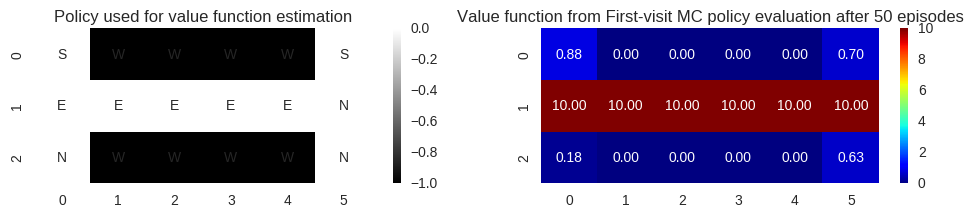

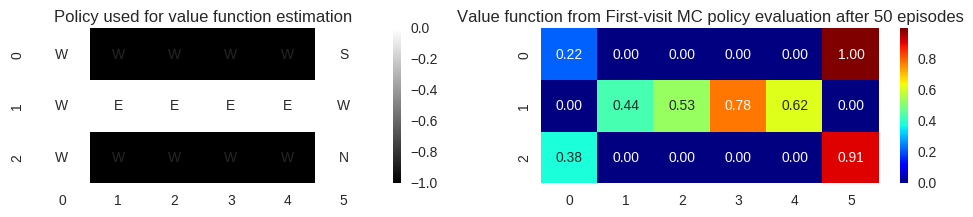

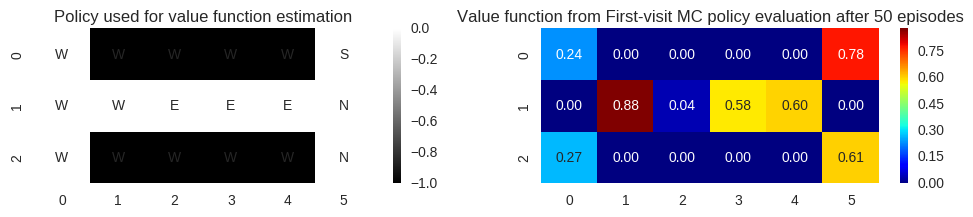

In [25]:
n_episodes = 50

for policy_arr in [greedy_default_policy_arr, greedy_another_policy_arr, greedy_some_other_policy_arr]:
    final_value_function = first_visit_mc_policy_evaluation(policy_arr, n_episodes)
    fig = plt.figure(figsize=(12, 2))
    plt.subplot(121)    
    plt.title("Policy used for value function estimation")
    display_policy_arr(policy_arr)
    plt.subplot(122)    
    plt.title("Value function from First-visit MC policy evaluation after %i episodes" % n_episodes)
    sns.heatmap(final_value_function, annot=True, fmt="0.2f", cmap='jet')

We see that value function estimation is closely related to the policy used for episode generation. The first policy bring the agent from the starting point to the end point. All the other polices stuck the agent at the starting position. So we observe random initialization of value functions in the displayed results.

### Monte Carlo Exploring Starts

This method estimates value function and updates the policy starting each episode from a random initial state and taking a random action.

In [26]:
del action_value_function

In [27]:
from collections import defaultdict
from operator import itemgetter

def init_random_policy():
    policy_arr = np.empty((GRID_HEIGHT, GRID_WIDTH), dtype=np.object)
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT): 
            policy_arr[y, x] = ACTIONS[np.random.randint(4)]
    return policy_arr

def init_random_action_values():
    action_value_function = {}
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT): 
            vals = []
            for a in ACTIONS:
                vals.append([a, np.random.rand()])
            action_value_function[(x, y)] = vals
    return action_value_function
    
def mc_exploring_starts(n_episodes):
    policy_arr = init_random_policy()    
    action_value_function = init_random_action_values()
    returns = defaultdict(list)
        
    for i in range(n_episodes):
        
        count = GRID_HEIGHT * GRID_WIDTH
        initial_state = (np.random.randint(GRID_WIDTH), np.random.randint(GRID_HEIGHT))
        while not on_bridge(initial_state[0], initial_state[1]) and count > 0:
            initial_state = (np.random.randint(GRID_WIDTH), np.random.randint(GRID_HEIGHT))
            count -= 1
        
        count = len(ACTIONS)
        initial_action = ACTIONS[np.random.randint(len(ACTIONS))]
        new_state = take_action(initial_state, initial_action)
        while not on_grid(new_state[0], new_state[1]) or not on_bridge(new_state[0], new_state[1]) and count > 0:
            initial_action = ACTIONS[np.random.randint(len(ACTIONS))]
            new_state = take_action(initial_state, initial_action)            
            count -= 1
            
        # Generate episode using current policy
        episode, reward = generate_episode(policy_arr, initial_state, initial_action)
        
        first_occurence = np.zeros((GRID_HEIGHT, GRID_WIDTH), dtype=bool)
        for state, action in episode:
            x, y = state
            if not first_occurence[y, x]:
                first_occurence[y, x] = 1
                returns[(state, action)].append(reward)
                mn = np.mean(returns[(state, action)])
                for i, (a, v) in enumerate(action_value_function[state]):
                    if a == action:
                        action_value_function[state][i][1] = mn
                        break

        for state, action in episode:
            x, y = state
            val = action_value_function[state]
            val = sorted(val, key=itemgetter(1), reverse=True)
            policy_arr[y, x] = val[0][0]                
                
    return policy_arr, action_value_function

In [28]:
def display_action_value_function(action_value_function):
    positions = {'N': [0.0, 0.25], 'S': [0.0, -0.25], 'W': [-0.25, 0.0], 'E': [0.25, 0.0]}
    sns.heatmap(GRID, cmap='gray')
    for y in range(GRID_HEIGHT):
        for x in range(GRID_WIDTH):
            actions_values = action_value_function[(x, y)]
            for a, v in actions_values:
                plt.text(x + 0.5 + positions[a][0], y + 0.5 + positions[a][1], "%0.2f" % v, va='center', ha='center')

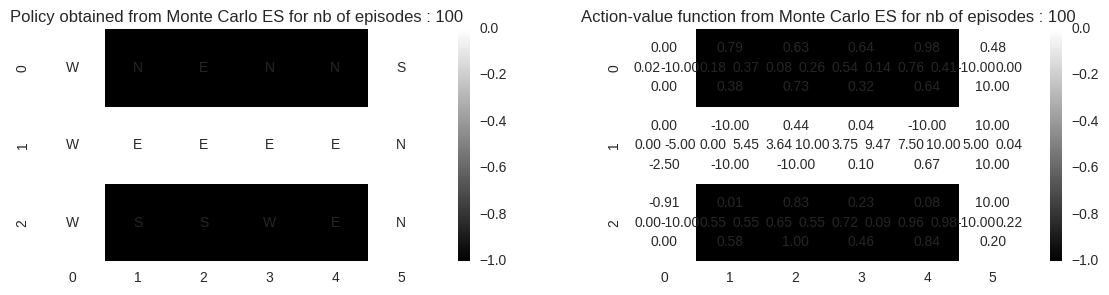

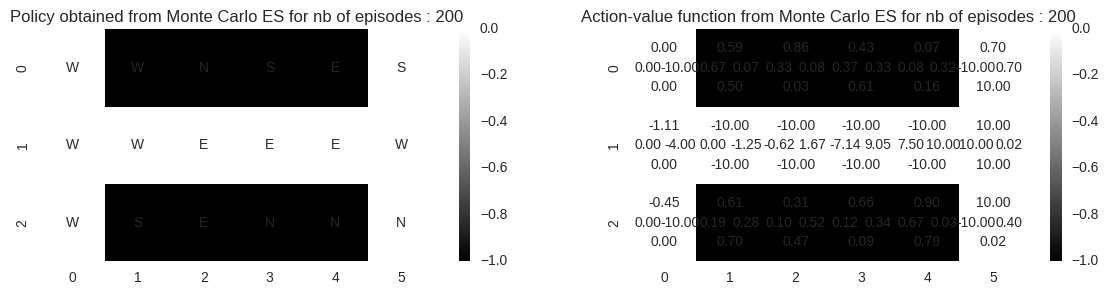

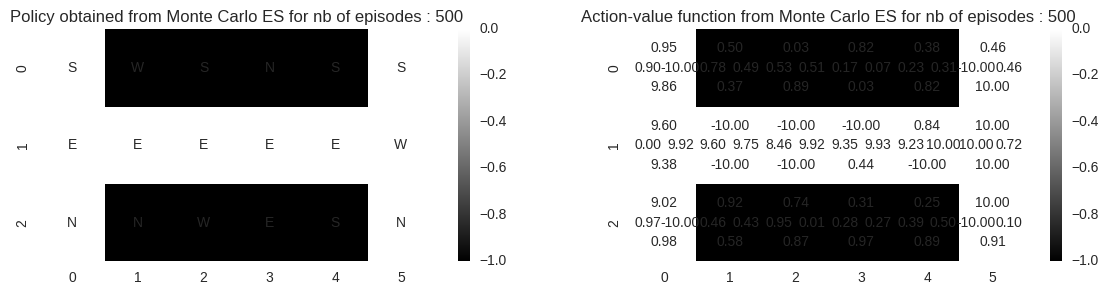

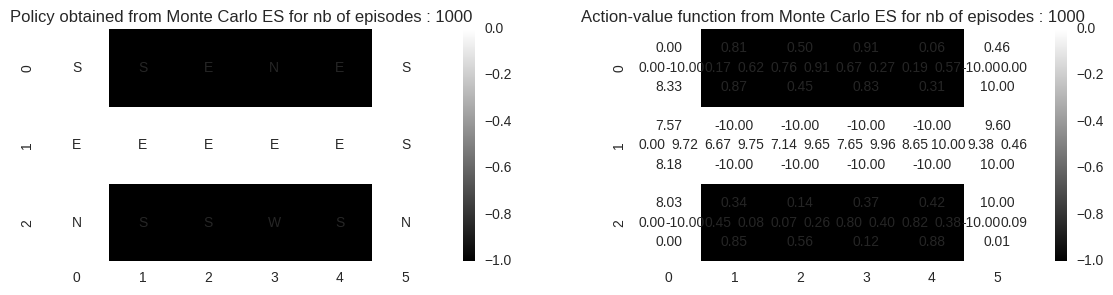

In [29]:
for n_episodes in [100, 200, 500, 1000]:
    final_policy, final_action_value_function = mc_exploring_starts(n_episodes)
    fig = plt.figure(figsize=(14, 3))
    plt.subplot(121)    
    plt.title("Policy obtained from Monte Carlo ES for nb of episodes : %i" % n_episodes)
    display_policy_arr(final_policy)
    plt.subplot(122)    
    plt.title("Action-value function from Monte Carlo ES for nb of episodes : %i" % n_episodes)
    display_action_value_function(final_action_value_function)

### On-policy first-visit Monte Carlo control

This algorithm avoid to use the unlikely assumption of exploring starts. 

Previously we implemented action-value function as a dictionary with state as key and list of pairs (action, value) as dictionary value. Below we implement action-value function as a 3D array `[x, y, a]`. Action's order is the same as in `ACTIONS`.

In [5]:
def inv_cdf(cdf, u):
    out = 0
    ll= len(cdf)
    for i in range(1, ll):
        if cdf[i-1] <= u < cdf[i]:
            out = i
            break
    return out

def get_policy_action(state, policy, return_index=False):
    x, y = state
    action_probas = policy[y, x, :]
    ll = len(action_probas)
    cdf = np.cumsum(action_probas)
    if return_index:
        index = inv_cdf(cdf, np.random.rand())
        return ACTIONS[index], index
    return ACTIONS[inv_cdf(cdf, np.random.rand())]

In [6]:
def init_random_e_soft_policy(epsilon):
    ll = len(ACTIONS)
    policy_arr = np.zeros((GRID_HEIGHT, GRID_WIDTH, ll))
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT): 
            action_star_index = np.random.randint(ll)
            for i in range(ll):
                policy_arr[y, x, i] = epsilon / ll
            policy_arr[y, x, action_star_index] = 1.0 - epsilon + epsilon / ll
            
    return policy_arr

def init_random_action_value_function(is_null_at_terminal=False):
    ll = len(ACTIONS)
    action_value_arr = np.zeros((GRID_HEIGHT, GRID_WIDTH, ll))
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT): 
            if (in_pit(x, y) or at_end_position(x, y)) and is_null_at_terminal:
                action_value_arr[y, x, :] = 0.0
            else:
                action_value_arr[y, x, :] = np.random.rand(ll)
    return action_value_arr    

def generate_episode2(policy):
    reward = 0    
    episode = [[START_POS, None]]
    state, action = episode[-1]
    episode_length = GRID_HEIGHT + GRID_WIDTH
    while episode_length > 0:
        episode_length -= 1        
        x, y = state        
        if action is None:
            action = get_policy_action(state, policy)
            episode[-1][1] = action
            
        nx, ny = take_action(state, action)
        if not on_grid(nx, ny):
            reward += REWARDS[2]
            continue
        elif on_bridge(nx, ny) and not at_end_position(nx, ny):
            reward += REWARDS[2]
        elif in_pit(nx, ny):
            episode_length = 0
            reward += REWARDS[0]
        elif at_end_position(nx, ny):
            episode_length = 0
            reward += REWARDS[1]            
        episode.append([(nx, ny), None])
        state, action = episode[-1]
    return episode, reward

def on_policy_first_visit_mc(n_episodes, epsilon):
    action_value_function = init_random_action_value_function()  
    policy = init_random_e_soft_policy(epsilon)
    returns = defaultdict(list)
        
    ll = len(ACTIONS)
    for i in range(n_episodes):
                    
        # Generate episode using current policy
        episode, reward = generate_episode2(policy)
        
        first_occurence = np.ones((GRID_HEIGHT, GRID_WIDTH), dtype=bool)
        for state, action in episode:
            x, y = state
            if first_occurence[y, x] and action is not None:
                action_index = ACTIONS.index(action)
                first_occurence[y, x] = 0
                returns[(state, action)].append(reward)
                mn = np.mean(returns[(state, action)])
                action_value_function[y, x, action_index] = mn
        
        for state, action in episode:
            x, y = state
            action_star_index = np.argmax(action_value_function[y, x, :])
            for i in range(ll):
                policy[y, x, i] = epsilon / ll
            policy[y, x, action_star_index] = 1.0 - epsilon + epsilon / ll
                
    return policy, action_value_function

In [12]:
def display_a_v_function(a_v_function):
    positions = {'N': [0.0, 0.25], 'S': [0.0, -0.25], 'W': [-0.25, 0.0], 'E': [0.25, 0.0]}
    sns.heatmap(GRID, cmap='gray')
    for y in range(GRID_HEIGHT):
        for x in range(GRID_WIDTH):
            actions_values = a_v_function[y,x,:]
            for i, v in enumerate(actions_values):
                a = ACTIONS[i]
                plt.text(x + 0.5 + positions[a][0], y + 0.5 + positions[a][1], "%0.2f" % v, va='center', ha='center')

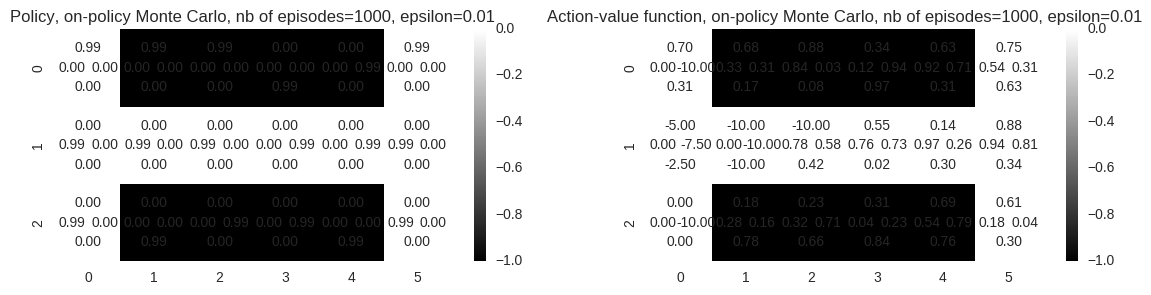

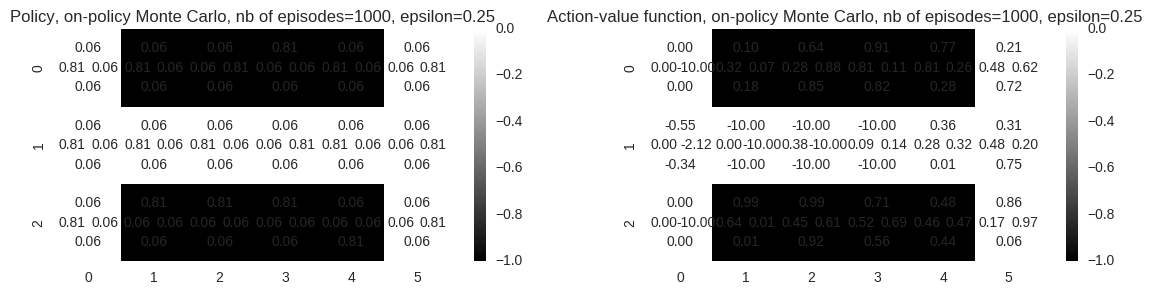

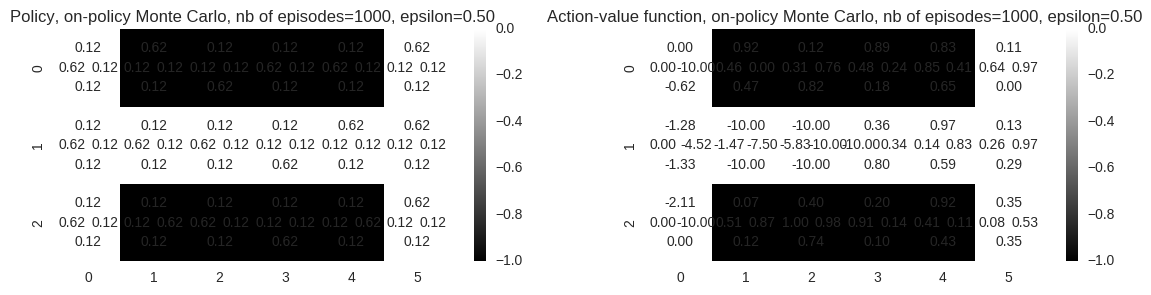

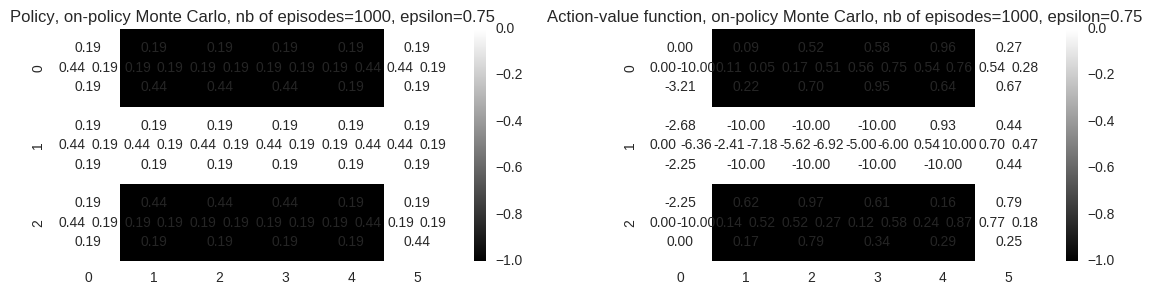

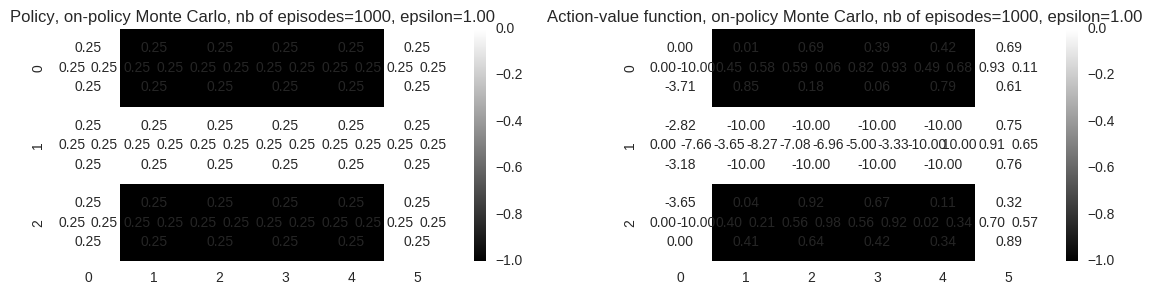

In [33]:
n_episodes = 1000
for epsilon in [0.01, 0.25, 0.5, 0.75, 1.0]:
    final_policy, final_action_value_function = on_policy_first_visit_mc(n_episodes=n_episodes, epsilon=epsilon)
    fig = plt.figure(figsize=(14, 3))
    plt.subplot(121)    
    plt.title("Policy, on-policy Monte Carlo, nb of episodes=%i, epsilon=%0.2f" % (n_episodes, epsilon))
    display_a_v_function(final_policy)
    plt.subplot(122)    
    plt.title("Action-value function, on-policy Monte Carlo, nb of episodes=%i, epsilon=%0.2f" % (n_episodes, epsilon))
    display_a_v_function(final_action_value_function)

We observe that found results are worse than those of Exploring Starts for the same number of episodes.

### Off-policy predictions

## Temporal Difference learning

Temporal difference methods and Monte Carlo methods estimates action value function and policy from *experience*. However, in contrast of Monte Carlo methods, temporal difference methods do not require to wait until episode end to update value function or action value function.

### Sarsa: An on-policy Temporal Difference control algorithm

In this algorithm we estimate action-value function $Q(s,a)$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t) \right]  
$$

For terminal state, $Q(s,a)=0$. The policy used to get actions from a state can be derived from $Q(s,a)$, for example using an $\epsilon$-*soft* method.

**Algorithm**
<br>
<div style="background-color: #aaaaaa; padding: 10px; width: 75%; border: solid black; border-radius: 5px;">

    Initialize $Q(s, a)$, for all $s \in \cal{S}$, $a \in \cal{A}(s)$, arbitrarily, and $Q(\text{terminal-state}, \cdot) = 0$<br>
    Repeat (for each episode):<br>
    &emsp;Initialize $S$<br>
    &emsp;Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br>
    &emsp;Repeat (for each step of episode):<br>
    &emsp;&emsp;Take action $A$, observe $R$, $S'$<br>
    &emsp;&emsp;Choose $A'$ from $S'$ using policy derived from Q (e.g., $\epsilon$-greedy)<br>
    &emsp;&emsp;$Q(S,A) \leftarrow Q(S,A) + \alpha \left[ R + \gamma Q(S', A') - Q(S,A) \right]$<br>
    &emsp;&emsp;$S \leftarrow S'; \, A \leftarrow A';$<br>
    &emsp;until $S$ is terminal
</div>

In [9]:
def compute_e_soft_policy(epsilon, action_value_function):
    ll = len(ACTIONS)
    policy_arr = np.zeros((GRID_HEIGHT, GRID_WIDTH, ll))
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT): 
            action_star_index = np.argmax(action_value_function[y, x, :])
            for i in range(ll):
                policy_arr[y, x, i] = epsilon / ll
            policy_arr[y, x, action_star_index] = 1.0 - epsilon + epsilon / ll
    return policy_arr
            
def td_sarsa(n_episodes, alpha, gamma, epsilon=0.1, action_value_function=None):
    # Initialize randomly Q(s,a)
    if action_value_function is None:
        action_value_function = init_random_action_value_function(is_null_at_terminal=True)
    
    policy = compute_e_soft_policy(epsilon, action_value_function)
    
    ll = len(ACTIONS)
    for i in range(n_episodes):

        episode_length = 10*(GRID_HEIGHT + GRID_WIDTH)
        state = START_POS
        action, action_index = get_policy_action(START_POS, policy, return_index=True)
        while episode_length > 0 and \
            (not at_end_position(state[0], state[1]) and not in_pit(state[0], state[1])):
            
            #print "state, action : ", state, action
            x, y = state
            episode_length -= 1 
            current_reward = 0
            nx, ny = take_action(state, action)
            if not on_grid(nx, ny):
                nx, ny = x, y
                current_reward = REWARDS[2]
            elif on_bridge(nx, ny) and not at_end_position(nx, ny):
                current_reward = REWARDS[2]
            elif in_pit(nx, ny):
                current_reward = REWARDS[0]
            elif at_end_position(nx, ny):
                current_reward = REWARDS[1] 
                
            new_state = (nx, ny)
            new_action, new_action_index  = get_policy_action(new_state, policy, return_index=True)
            
            # Update Q(s,a)
            v = action_value_function[y, x, action_index]
            nv = action_value_function[ny, nx, new_action_index]
            t = alpha * (current_reward + gamma * nv - v) 
            action_value_function[y, x, action_index] += t
            
            # Update policy from Q(s,a) using epsilon-soft strategy
            action_star_index = np.argmax(action_value_function[y, x, :])
            for i in range(ll):
                policy[y, x, i] = epsilon / ll
            policy[y, x, action_star_index] = 1.0 - epsilon + epsilon / ll

            state, action, action_index = new_state, new_action, new_action_index
                
    return policy, action_value_function

The trials gives the following results:

**Case A)** Reward is null when on staying on the bridge. We vary the value of $\epsilon$-soft strategy to explore other states.

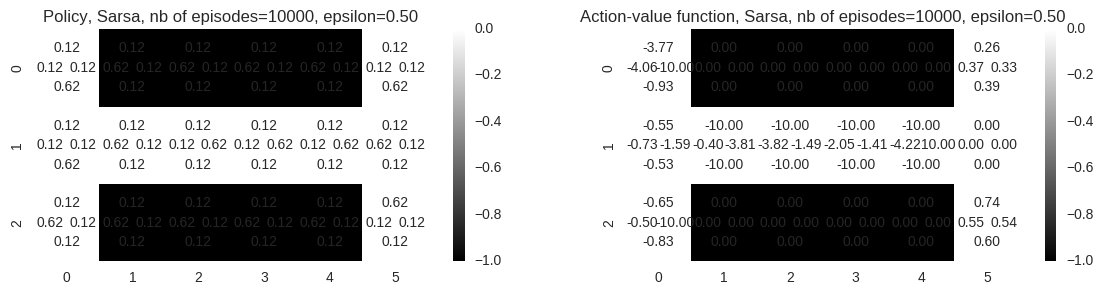

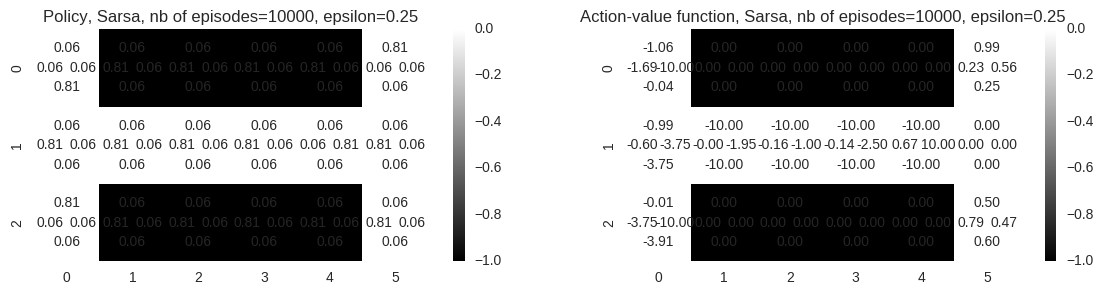

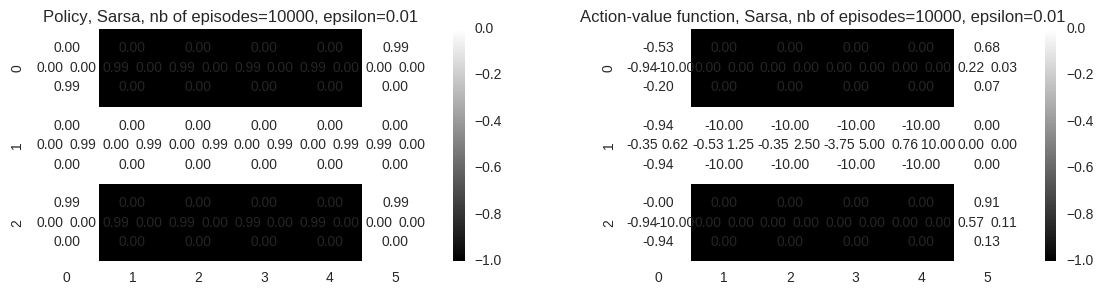

In [35]:
REWARDS[2] = 0.0
n_episodes=10000
alpha=0.75
gamma=0.5
for epsilon in [0.5, 0.25, 0.01]:

    final_policy, final_action_value_function = td_sarsa(n_episodes, alpha, gamma, epsilon)
    fig = plt.figure(figsize=(14, 3))
    plt.subplot(121)    
    plt.title("Policy, Sarsa, nb of episodes=%i, epsilon=%0.2f" % (n_episodes, epsilon))
    display_a_v_function(final_policy)
    plt.subplot(122)    
    plt.title("Action-value function, Sarsa, nb of episodes=%i, epsilon=%0.2f" % (n_episodes, epsilon))
    display_a_v_function(final_action_value_function)

We observe that the agent once on the bridge equally prefers to go away from the bridge. The policy being $\epsilon$-soft suggests to the agent to stay around the start position. Final policy, however, depends on  initialization values. The probability that the agent crosses the bridge is small.

**Case B)** Reward on staying on the bridge is a small negative value to avoid the agent to get stucked. Adopt a greedy policy.


New rewards :  [-10, 10, -0.3]


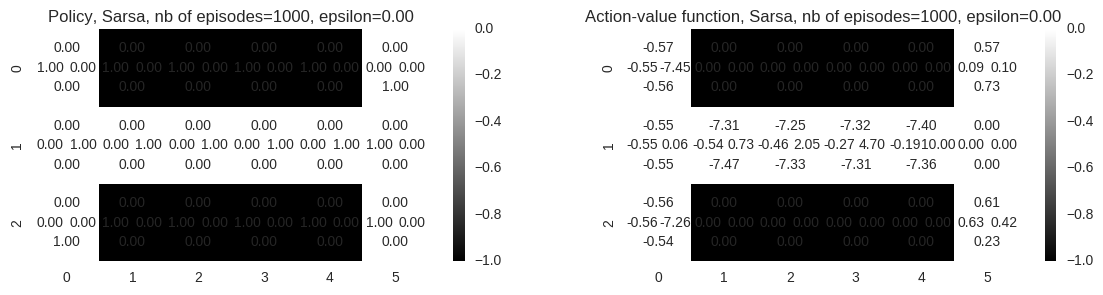

In [36]:
REWARDS[2] = -0.3
print "New rewards : ", REWARDS

n_episodes=1000
alpha=0.75
gamma=0.5
epsilon=0.0001

final_policy, final_action_value_function = td_sarsa(n_episodes, alpha, gamma, epsilon)
fig = plt.figure(figsize=(14, 3))
plt.subplot(121)    
plt.title("Policy, Sarsa, nb of episodes=%i, epsilon=%0.2f" % (n_episodes, epsilon))
display_a_v_function(final_policy)
plt.subplot(122)    
plt.title("Action-value function, Sarsa, nb of episodes=%i, epsilon=%0.2f" % (n_episodes, epsilon))
display_a_v_function(final_action_value_function)

In [37]:
REWARDS[2] = 0.0

### Q-learning: Off-Policy Temporal Difference Control

In this algorithm we estimate action-value function $Q(s,a)$ as :
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a) - Q(S_t,A_t) \right], \, Q(\cal{S}^{+},a)=0
$$

**Algorithm**
<br>
<div style="background-color: #aaaaaa; padding: 10px; width: 75%; border: solid black; border-radius: 5px;">

    Initialize $Q(s, a)$, for all $s \in \cal{S}$, $a \in \cal{A}(s)$, arbitrarily, and $Q(\text{terminal-state}, \cdot) = 0$<br>
    Repeat (for each episode):<br>
    &emsp;Initialize $S$<br>
    &emsp;Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)<br>
    &emsp;Repeat (for each step of episode):<br>
    &emsp;&emsp;Take action $A$, observe $R$, $S'$<br>
    &emsp;&emsp;$Q(S,A) \leftarrow Q(S,A) + \alpha \left[ R + \gamma \max_{a}Q(S', a) - Q(S,A) \right]$<br>
    &emsp;&emsp;$S \leftarrow S'; \, A \leftarrow A';$<br>
    &emsp;until $S$ is terminal
</div>

In [10]:
def q_learning(n_episodes, alpha, gamma, epsilon=0.1, action_value_function=None):
    # Initialize randomly Q(s,a)
    if action_value_function is None:
        action_value_function = init_random_action_value_function(is_null_at_terminal=False)
    
    policy = compute_e_soft_policy(epsilon, action_value_function)
    
    ll = len(ACTIONS)
    for i in range(n_episodes):

        episode_length = 10*(GRID_HEIGHT + GRID_WIDTH)
        state = START_POS
        action, action_index = get_policy_action(START_POS, policy, return_index=True)
        while episode_length > 0 and \
            (not at_end_position(state[0], state[1]) and not in_pit(state[0], state[1])):
            
            #print "state, action : ", state, action
            x, y = state
            episode_length -= 1 
            current_reward = 0
            nx, ny = take_action(state, action)
            if not on_grid(nx, ny):
                nx, ny = x, y
                current_reward = REWARDS[2]
            elif on_bridge(nx, ny) and not at_end_position(nx, ny):
                current_reward = REWARDS[2]
            elif in_pit(nx, ny):
                current_reward = REWARDS[0]
            elif at_end_position(nx, ny):
                current_reward = REWARDS[1] 
                
            new_state = (nx, ny)
            new_action, new_action_index = get_policy_action(new_state, policy, return_index=True)
            
            # Update Q(s,a)
            v = action_value_function[y, x, action_index]
            nv = np.max(action_value_function[ny, nx, :])
            t = alpha * (current_reward + gamma * nv - v) 
            action_value_function[y, x, action_index] += t
            
            # Update policy from Q(s,a) using epsilon-soft strategy
            action_star_index = np.argmax(action_value_function[y, x, :])
            for i in range(ll):
                policy[y, x, i] = epsilon / ll
            policy[y, x, action_star_index] = 1.0 - epsilon + epsilon / ll

            state, action, action_index = new_state, new_action, new_action_index
                
    return policy, action_value_function

At first we will see the result of action-value function estimation when $\alpha$ varies. Small values of $\alpha$ tend to ignore action-value function updates. Large values of $\alpha$ tend ignore previously found value of the action-value function.

NameError: name 'display_a_v_function' is not defined

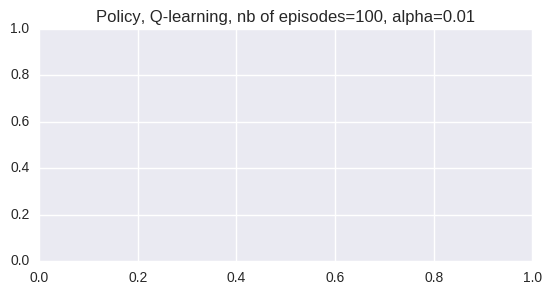

In [11]:
n_episodes=100
gamma=0.5
epsilon=0.35

for alpha in [0.01, 0.5, 0.75, 1.0]:
    final_policy, final_action_value_function = q_learning(n_episodes, alpha, gamma, epsilon)
    fig = plt.figure(figsize=(14, 3))
    plt.subplot(121)    
    plt.title("Policy, Q-learning, nb of episodes=%i, alpha=%0.2f" % (n_episodes, alpha))
    display_a_v_function(final_policy)
    plt.subplot(122)    
    plt.title("Action-value function, Q-learning, nb of episodes=%i, alpha=%0.2f" % (n_episodes, alpha))
    display_a_v_function(final_action_value_function)


Next we will see the result of action-value function estimation when $\gamma$ varies. This parameter controls future steps reward *discount*. Small values of $\gamma$ tend ignore future step knowledge and make agent to grab the closest largest reward. Large values of $\gamma$ consider also future step action-value function.

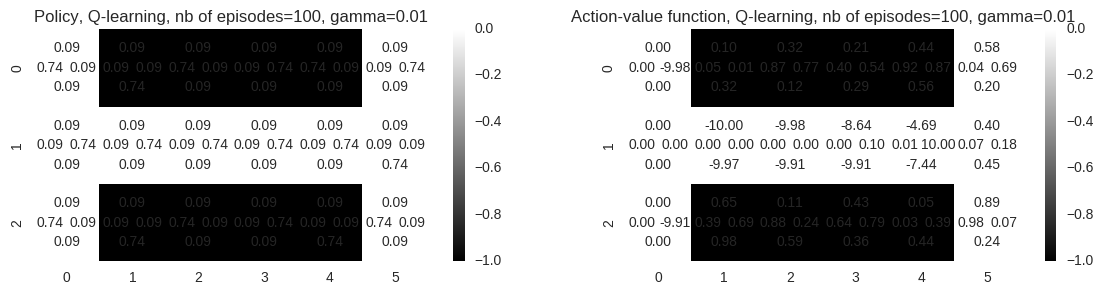

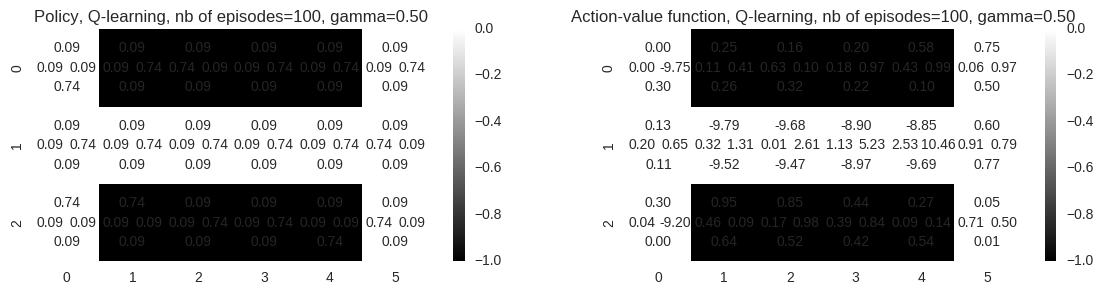

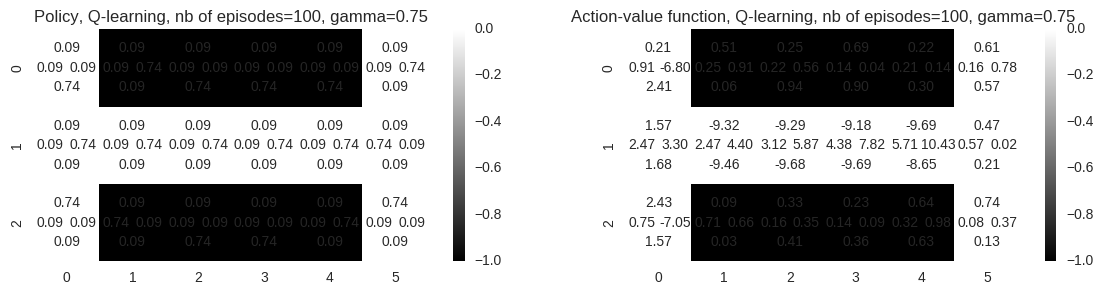

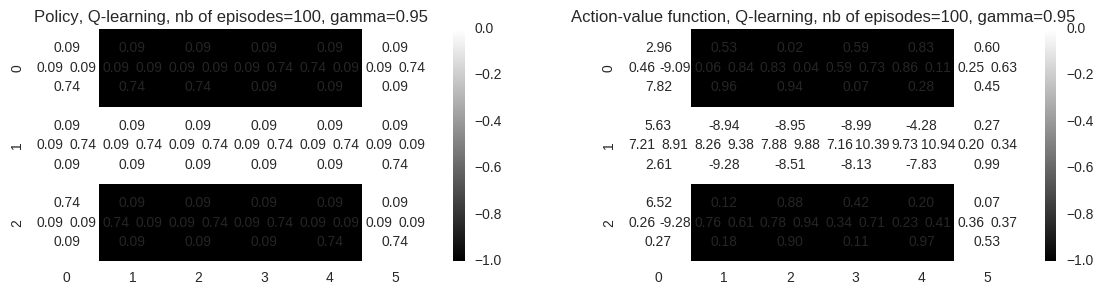

In [13]:
n_episodes=100

alpha=0.5
epsilon=0.35

for gamma in [0.01, 0.5, 0.75, 0.95]:
    final_policy, final_action_value_function = q_learning(n_episodes, alpha, gamma, epsilon)
    fig = plt.figure(figsize=(14, 3))
    plt.subplot(121)    
    plt.title("Policy, Q-learning, nb of episodes=%i, gamma=%0.2f" % (n_episodes, gamma))
    display_a_v_function(final_policy)
    plt.subplot(122)    
    plt.title("Action-value function, Q-learning, nb of episodes=%i, gamma=%0.2f" % (n_episodes, gamma))
    display_a_v_function(final_action_value_function)
